In [1]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import files

In [2]:
uploaded = files.upload()

Saving PM25.csv to PM25.csv


In [3]:
df = pd.read_csv(open("PM25.csv", "r"))

In [4]:
#make sure it's the right dataset
df.head()

,day (cumulative),pm2.5,DEWP,TEMP,PRES,Iws,cbwd,Rain hours,Snow hours
0,1,145.958333,-18.750000,-6.750000,1017.083333,14.458333,NW,0,0
1,2,145.958333,-8.500000,-5.125000,1024.750000,24.860000,SE,0,4
2,3,78.833333,-10.125000,-8.541667,1022.791667,70.937917,SE,0,24
3,4,31.333333,-20.875000,-11.500000,1029.291667,111.160833,NW,0,0
4,5,42.458333,-24.583333,-14.458333,1033.625000,56.920000,NW,0,0


In [5]:
#sanity check - measurements are definitely taken in celsius
print(df['DEWP'].max())
print(df['DEWP'].min())

26.20833333333333
-33.333333333333336


In [6]:
#drop cbwd because it's going to require different NN architecture to predict, and VAR won't work
df = df[['day (cumulative)','pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']]
df.head()

,day (cumulative),pm2.5,DEWP,TEMP,PRES,Iws,Rain hours,Snow hours
0,1,145.958333,-18.750000,-6.750000,1017.083333,14.458333,0,0
1,2,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0,4
2,3,78.833333,-10.125000,-8.541667,1022.791667,70.937917,0,24
3,4,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0,0
4,5,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0,0


In [7]:
#drop day column, we don't need ot
df_no_day = df[['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']]
df_no_day.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Rain hours,Snow hours
0,145.958333,-18.750000,-6.750000,1017.083333,14.458333,0,0
1,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0,4
2,78.833333,-10.125000,-8.541667,1022.791667,70.937917,0,24
3,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0,0
4,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0,0


Visualizations go here

In [8]:
import matplotlib.pyplot as plt

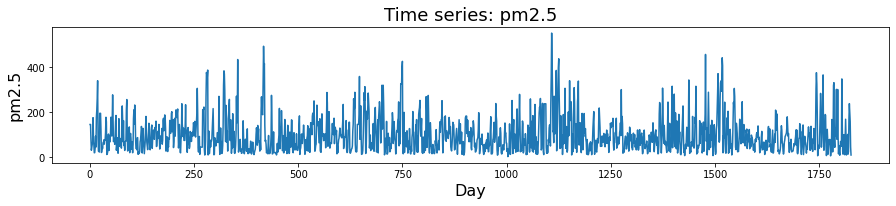

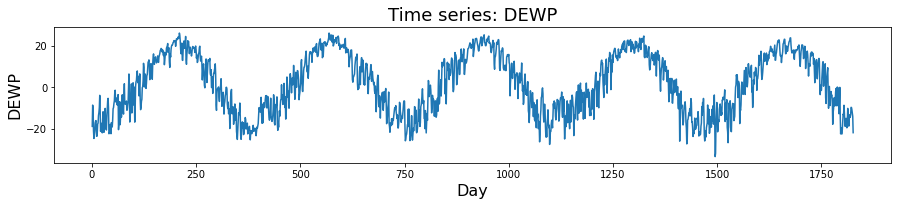

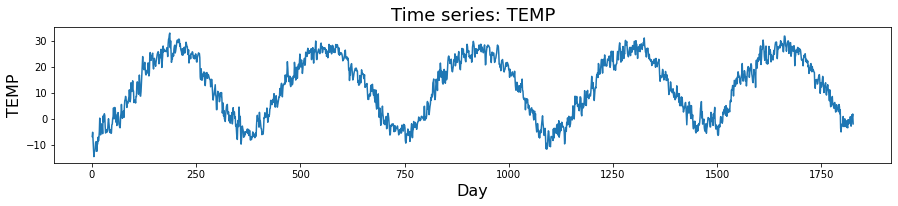

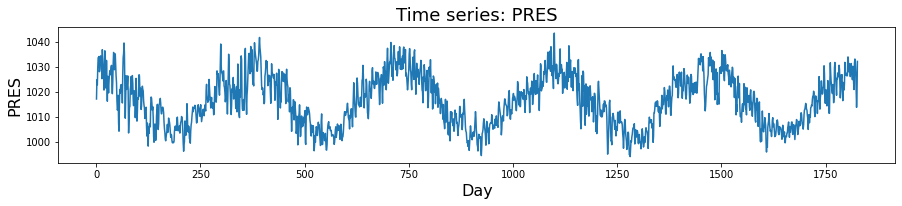

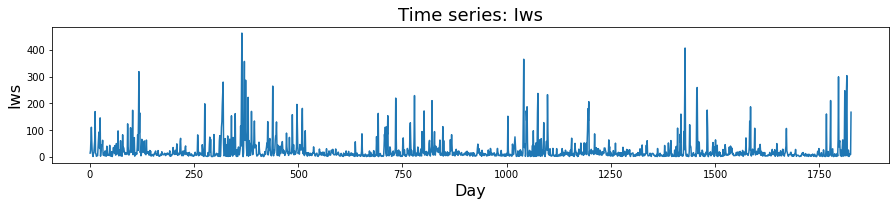

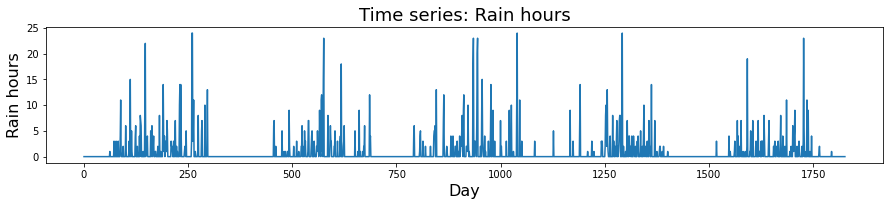

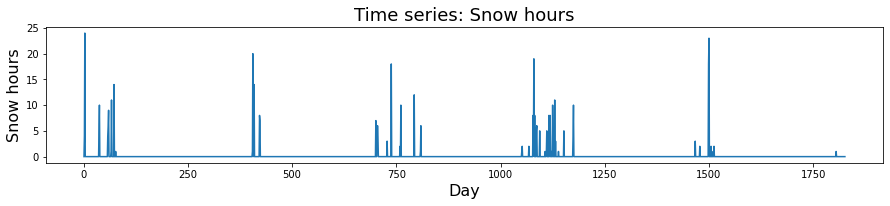

In [9]:
#what does our data look like?
indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']
for i in indices:
  fig = plt.figure(figsize =(15, 2.5)) 
  plt.title("Time series: " + i, size=18) 
  plt.xlabel('Day', size=16)
  plt.ylabel(i, size=16)
  plt.plot(df['day (cumulative)'],df[i])
  plt.show()

dataset normalization

In [10]:
from sklearn import preprocessing

np_values_array = df[['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']].values
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled_values = min_max_scaler.fit_transform(np_values_array)
df_normal = pd.DataFrame(df_scaled_values, columns = indices)
df_normal_day = df_normal.copy()
df_normal_day['day'] = df['day (cumulative)']

In [11]:
df.head()

,day (cumulative),pm2.5,DEWP,TEMP,PRES,Iws,Rain hours,Snow hours
0,1,145.958333,-18.750000,-6.750000,1017.083333,14.458333,0,0
1,2,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0,4
2,3,78.833333,-10.125000,-8.541667,1022.791667,70.937917,0,24
3,4,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0,0
4,5,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0,0


In [12]:
df_normal.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Rain hours,Snow hours
0,0.260227,0.244927,0.162852,0.466273,0.028251,0.0,0.000000
1,0.260227,0.417075,0.197183,0.621417,0.050777,0.0,0.166667
2,0.138075,0.389783,0.125000,0.581788,0.150561,0.0,1.000000
3,0.051636,0.209237,0.062500,0.713322,0.237666,0.0,0.000000
4,0.071881,0.146956,0.000000,0.801012,0.120205,0.0,0.000000


sanity check for normal values

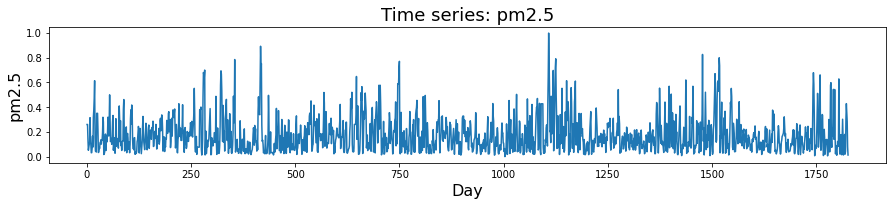

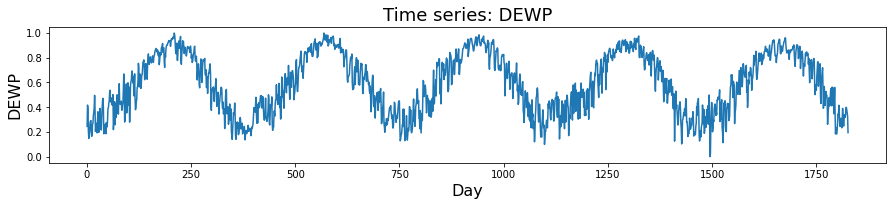

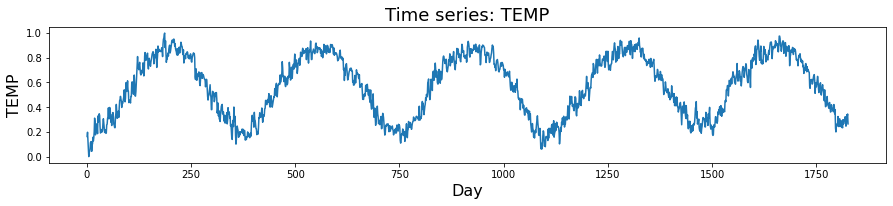

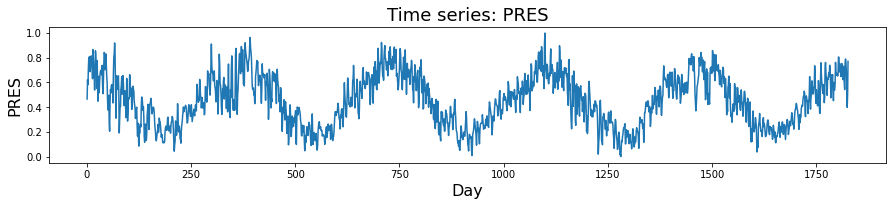

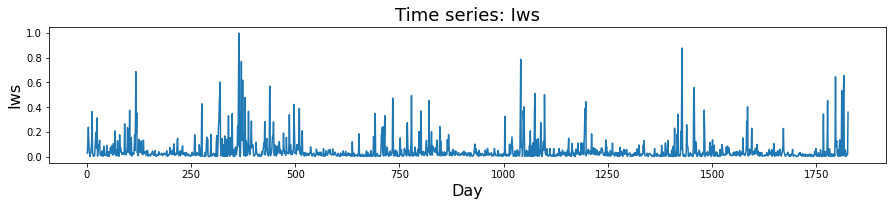

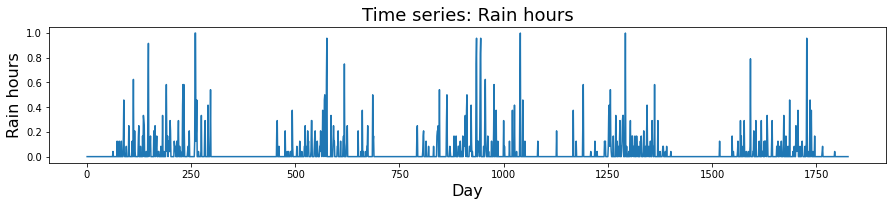

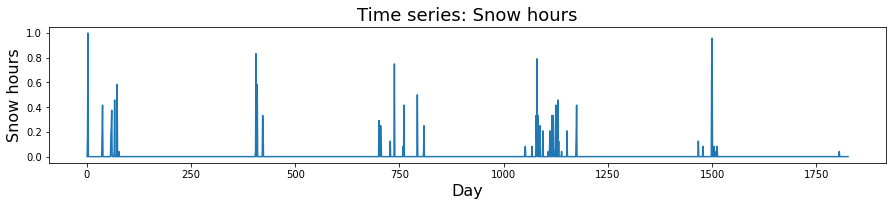

In [13]:
indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']
for i in indices:
  fig = plt.figure(figsize =(15, 2.5)) 
  plt.title("Time series: " + i, size=18) 
  plt.xlabel('Day', size=16)
  plt.ylabel(i, size=16)
  plt.plot(df_normal_day['day'],df_normal_day[i])
  plt.show()


VAR goes here

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
#m = VAR(df_normal.iloc[0:731])
#r = m.fit(1)
#var_model is the model, df_arg is the dataframe, percentage_train is how much of the DF was used to train
#this just grabs the MSE of a VAR model with predicted values against the next interval
def var_predictions_mse(var_model, df_arg, percentage_train, lag_order):
  predictions = var_model.forecast(df_arg.iloc[lag_order+int(np.ceil((percentage_train-0.2)*len(df_arg))):int(np.ceil((percentage_train)*len(df_arg)))].values, 365)
  temp_values = df_arg.iloc[lag_order+int(np.ceil(percentage_train*len(df_arg))):int(np.ceil((percentage_train+0.2)*len(df_arg)))].values
  differences = predictions[:len(temp_values)] - temp_values
  mses = []
  for i in differences:
    temp_list = []
    for x in i:
      temp_list.append(x*x)
    mses.append(sum(temp_list)/7)
  return sum(mses)/len(mses)

#print(var_prediction_mse(r, df_normal, 0.4, 2))

In [16]:
#results_list = []
#for i in range(20):
#  results = model.fit(i+1)
#  #results.summary()
#  results_list.append(results)

In [17]:
#set up models...
model_normal_20 = VAR(df_normal.iloc[:365])
model_normal_40 = VAR(df_normal.iloc[:731])
model_normal_60 = VAR(df_normal.iloc[:1096])
model_normal_80 = VAR(df_normal.iloc[:1461])

In [18]:
#fit models
#this is a ton, i am shocked that this didn't crash
#guess VAR is very simple
results_list_normal_20 = []
for i in range(20):
  results = model_normal_20.fit(i+1)
  #results.summary()
  results_list_normal_20.append(results)
results_list_normal_40 = []
for i in range(20):
  results = model_normal_40.fit(i+1)
  #results.summary()
  results_list_normal_40.append(results)
results_list_normal_60 = []
for i in range(20):
  results = model_normal_60.fit(i+1)
  #results.summary()
  results_list_normal_60.append(results)
results_list_normal_80 = []
for i in range(20):
  results = model_normal_80.fit(i+1)
  #results.summary()
  results_list_normal_80.append(results)

In [19]:
#AIC and MSE for VAR models
#temp_list here takes the mean of the model scores (same architecture but trained on training sets of differing sizes - cross validation)
temp_list = []
temp_list_unagg = []
for i in range(1,21):
  print('Lag Order =', i)
  print('20% training')
  print('AIC : ', results_list_normal_20[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i))
  print('40% training')
  print('AIC : ', results_list_normal_40[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i))  
  print('60% training')
  print('AIC : ', results_list_normal_60[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i))  
  print('80% training')
  print('AIC : ', results_list_normal_80[i-1].aic)
  print('MSE : ', var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i))  
  temp_list.append([i, (results_list_normal_20[i-1].aic+results_list_normal_40[i-1].aic+results_list_normal_60[i-1].aic+results_list_normal_80[i-1].aic)/4,
                    (var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i)+var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i)+var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i)+var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i))/4,
                    (np.sqrt(var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i))+np.sqrt(var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i))+np.sqrt(var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i))+np.sqrt(var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i)))/4])
  temp_list_unagg.append([i, 0.2,results_list_normal_20[i-1].aic, var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i), np.sqrt(var_predictions_mse(results_list_normal_20[i-1], df_normal, 0.2, i))])
  temp_list_unagg.append([i, 0.4,results_list_normal_40[i-1].aic, var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i), np.sqrt(var_predictions_mse(results_list_normal_40[i-1], df_normal, 0.4, i))])
  temp_list_unagg.append([i, 0.6,results_list_normal_60[i-1].aic, var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i), np.sqrt(var_predictions_mse(results_list_normal_60[i-1], df_normal, 0.6, i))])
  temp_list_unagg.append([i, 0.8,results_list_normal_80[i-1].aic, var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i), np.sqrt(var_predictions_mse(results_list_normal_80[i-1], df_normal, 0.8, i))])

Lag Order = 1
20% training
AIC :  -36.29911046665786
MSE :  0.02642001958406455
40% training
AIC :  -37.21451859994303
MSE :  0.026713530690545165
60% training
AIC :  -37.13774266351284
MSE :  0.025777660908980992
80% training
AIC :  -37.23659610153114
MSE :  0.02412482346972258
Lag Order = 2
20% training
AIC :  -36.559411958398144
MSE :  0.02590241748800515
40% training
AIC :  -37.414114357327485
MSE :  0.028713497464596862
60% training
AIC :  -37.35182189437906
MSE :  0.027941919116491205
80% training
AIC :  -37.45639819316884
MSE :  0.024969266099771893
Lag Order = 3
20% training
AIC :  -37.214463867473334
MSE :  0.02639648754940265
40% training
AIC :  -37.78644587725062
MSE :  0.029508143696405153
60% training
AIC :  -37.572598557753146
MSE :  0.029425546890806467
80% training
AIC :  -37.63941413377865
MSE :  0.025441220482986606
Lag Order = 4
20% training
AIC :  -37.12479340196693
MSE :  0.02600055015250504
40% training
AIC :  -37.756304411685434
MSE :  0.03046962324166293
60% tra

In [20]:
#format it as a nice little DF and we are done
VAR_results_df = pd.DataFrame(temp_list, columns=['Order','AIC','MSE','RMSE'])
VAR_results_df

,Order,AIC,MSE,RMSE
0,1,-36.971992,0.025759,0.160465
1,2,-37.195437,0.026882,0.163892
2,3,-37.553231,0.027693,0.166323
3,4,-37.524740,0.028140,0.167599
4,5,-37.465152,0.027953,0.166991
5,6,-37.416288,0.029011,0.170020
6,7,-37.373152,0.030368,0.173905
7,8,-37.339114,0.029764,0.172216
8,9,-37.311338,0.029388,0.171068
9,10,-37.263677,0.029624,0.171787


In [23]:
VAR_results_df_unagg = pd.DataFrame(temp_list_unagg, columns=['Order','Training Percent','AIC','MSE','RMSE'])
VAR_results_df_unagg

,Order,Training Percent,AIC,MSE,RMSE
0,1,0.2,-36.299110,0.026420,0.162542
1,1,0.4,-37.214519,0.026714,0.163443
2,1,0.6,-37.137743,0.025778,0.160554
3,1,0.8,-37.236596,0.024125,0.155322
4,2,0.2,-36.559412,0.025902,0.160942
...,...,...,...,...,...
75,19,0.8,-37.382221,0.017720,0.133116
76,20,0.2,-35.717437,0.024712,0.157199
77,20,0.4,-36.994265,0.028186,0.167886
78,20,0.6,-37.083954,0.019944,0.141223


LSTM goes here

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
dfvalues = df_no_day.values.astype('float32')
dfnvalues = df_normal.values.astype('float32')

In [25]:
#refactored code for the LSTM network, architecture can be adjusted

In [26]:
#these are divided by the number of predicted features to give you average error per feature
def calculate_mse_interval(model, testx, testy):
  index = 0
  prediction_vector = model.predict(testx)
  difference_vector = prediction_vector - testy
  mses = []
  for i in difference_vector:
    mses.append(sum(i*i)/7)
  return sum(mses)/len(mses)

def calculate_mae_interval(model, testx, testy):
  index = 0
  prediction_vector = model.predict(testx)
  difference_vector = prediction_vector - testy
  maes = []
  for i in difference_vector:
    maesl = []
    for x in i:
      maesl.append(np.abs(x))
    maes.append(sum(maesl)/7)
  return sum(maes)/len(maes)

#this doesn't work because some observations are 0
#also because the values are normalized
#MAPE is just a bad choice for evaluating this kind of model
#def calculate_mape_interval(model, testx, testy):
#  index = 0
#  prediction_vector = model.predict(testx)
#  mapes = []
#  index = 0
#  for i in testy:
#    mapesl = []
#    index_y = 0
#    for x in i:
#      mapesl.append(np.abs(x-prediction_vector[index][index_y])/x)
#      index_y += 1
#    mapes.append(sum(mapesl))
#    index += 1
#  return sum(mapes)/len(mapes)

In [27]:
#assume values are normalized, but could be interested to see results if they are not
#ARGUMENTS:
#df_arg = dataframe with normalized values, only features that are relevant
#time_lags = number of time steps to look back in time
#train_size = percentage of data (from the first normalized dataset, not the time-series shifted one) to use for training
#directions = 1 or 2, either unidirectional or bidirectional LSTM layers
#number_of_layers = do i really need to explain this?
#dropout_percent = dropout value for LSTM layers
#number_of_epochs = also pretty self explanatory
def LSTM_function(df_arg, time_lags, train_size, directions, number_of_layers, dropout_percent, number_of_epochs):
  indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']

  #dfnl stands for dataframe normalized with lags
  dfnl = df_arg.copy()

  #set up time series with lags
  for i in range(1, time_lags):
    for ind in indices:
      dfnl[ind+'_lag_'+str(i)] = df_arg.shift(periods=i)[ind]

  #v for values
  dfnlv = dfnl.values.astype('float32')

  #what an ugly two lines of code! it's supposed to break up the test and train set into train_size percent, and 1-train_size percent for test
  train = dfnlv[time_lags:int(np.ceil(train_size*len(df_arg)))]
  test = dfnlv[int(np.ceil(train_size*len(df_arg))):int(np.ceil((train_size+0.2)*len(df_arg)))]

  #split into predicted and unpredicted values
  trainx, trainy = train[:, :7*(time_lags-1)], train[:, 7*(time_lags-1):]
  testx, testy = test[:, :7*(time_lags-1)], test[:, 7*(time_lags-1):]

  #reshape into the LSTM RNN desired shape
  trainxr = trainx.reshape((trainx.shape[0], 1, trainx.shape[1]))
  testxr = testx.reshape((testx.shape[0], 1, testx.shape[1]))
  
  #choice of model architecture, this should be modular depending on kwargs
  #you can actually add any number of layers if you want
  model = keras.Sequential()
  if (number_of_layers==1):
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))

  else:
    for i in range(number_of_layers-1):
      if (directions==1):
        model.add(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent))
      elif (directions==2):
        model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent)))
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))       
  model.add(layers.Dense(7))

  #compile with MSE and adam optimizer
  model.compile(loss='mse', optimizer='adam')

  history = model.fit(trainxr, trainy, epochs=number_of_epochs, batch_size=50, validation_data=(testxr, testy), verbose=2, shuffle=False)

  #plot the loss values 
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Test loss')
  plt.legend()
  plt.show()

  #model summary
  print(model.summary())
  print("Model parameters: ")
  print("Time lags: ", time_lags)
  print("Training set size: "+str(train_size*100)+"%, or "+str(train_size*1825-time_lags))
  print("Number of epochs: "+str(number_of_epochs))
  print("Number of layers: "+str(number_of_layers))
  print("Dropout percent: "+str(dropout_percent))
  mae_interval = calculate_mae_interval(model, testxr, testy)
  print("MAE (interval): ", mae_interval)
  mse_interval = calculate_mse_interval(model, testxr, testy)
  print("MSE (interval): ", mse_interval)
  rmse_interval = np.sqrt(calculate_mse_interval(model, testxr, testy))
  print("RMSE (interval): ", rmse_interval)  

  #return all parameters that you need for evaluation
  return [time_lags, train_size, directions, number_of_layers, dropout_percent, number_of_epochs, mae_interval, mse_interval, rmse_interval]
#  return model

#m = LSTM_function(df_normal, 10, 0.2, 2, 2, 0, 100)

In [28]:
#reposted from above
#ARGUMENTS:
#df_arg = dataframe with normalized values, only features that are relevant
#time_lags = number of time steps to look back in time
#train_size = percentage of data (from the first normalized dataset, not the time-series shifted one) to use for training
#directions = 1 or 2, either unidirectional or bidirectional LSTM layers
#number_of_layers = do i really need to explain this?
#dropout_percent = dropout value for LSTM layers
#number_of_epochs = also pretty self explanatory
timelags = [10,20]
num_layers = [1,2]
directions = [1,2]
dropouts = [0,0.2,0.4]
cross_validation_intervals = [0.2,0.4,0.6,0.8]
#m = LSTM_function(df_normal, 10, 0.2, 2, 2, 0, 100)

In [30]:
#iterate through everything
#this takes a long time to run
model_results_list = []
for t in timelags:
  for n in num_layers:
    for dirs in directions:
      for d in dropouts:
        for c in cross_validation_intervals:
          model_results_list.append(LSTM_function(df_normal, t, c, dirs, n, d, 100))

Output hidden; open in https://colab.research.google.com to view.

In [31]:
#get results and put into df
LSTM_results_df = pd.DataFrame(model_results_list, columns=['Time lags', 'Train size', 'Number of directions', 'Number of layers', 'Dropout percent', 'Number of epochs', 'MAE (interval)', 'MSE (interval)', 'RMSE (interval)'])
LSTM_results_df

,Time lags,Train size,Number of directions,Number of layers,Dropout percent,Number of epochs,MAE (interval),MSE (interval),RMSE (interval)
0,10,0.2,1,1,0.0,100,0.117963,0.027341,0.165352
1,10,0.4,1,1,0.0,100,0.086570,0.015828,0.125808
2,10,0.6,1,1,0.0,100,0.067952,0.010475,0.102349
3,10,0.8,1,1,0.0,100,0.063446,0.009754,0.098761
4,10,0.2,1,1,0.2,100,0.117339,0.027033,0.164417
...,...,...,...,...,...,...,...,...,...
91,20,0.8,2,2,0.2,100,0.087325,0.016468,0.128328
92,20,0.2,2,2,0.4,100,0.120683,0.028796,0.169693
93,20,0.4,2,2,0.4,100,0.113733,0.025975,0.161169
94,20,0.6,2,2,0.4,100,0.101734,0.021613,0.147012


In [32]:
#cross-validate models
MAE_temp = []
MSE_temp = []
RMSE_temp = []
model_temp = []
index = 1
for i in LSTM_results_df.iterrows():
  MAE_temp.append(i[1][6])
  MSE_temp.append(i[1][7])
  RMSE_temp.append(i[1][8])    
  if ((index%4)==0):
    model_temp.append([np.mean(MAE_temp),np.mean(MSE_temp),np.mean(RMSE_temp)])
    model_temp.append([np.mean(MAE_temp),np.mean(MSE_temp),np.mean(RMSE_temp)])
    model_temp.append([np.mean(MAE_temp),np.mean(MSE_temp),np.mean(RMSE_temp)])
    model_temp.append([np.mean(MAE_temp),np.mean(MSE_temp),np.mean(RMSE_temp)])            
    MAE_temp.clear()
    MSE_temp.clear()
    RMSE_temp.clear()
  index+=1
print(model_temp)

[[0.08398270551444961, 0.015849478337076117, 0.12306738710789358], [0.08398270551444961, 0.015849478337076117, 0.12306738710789358], [0.08398270551444961, 0.015849478337076117, 0.12306738710789358], [0.08398270551444961, 0.015849478337076117, 0.12306738710789358], [0.08431954855868593, 0.015895296178798174, 0.12348111899466471], [0.08431954855868593, 0.015895296178798174, 0.12348111899466471], [0.08431954855868593, 0.015895296178798174, 0.12348111899466471], [0.08431954855868593, 0.015895296178798174, 0.12348111899466471], [0.08652663282558627, 0.016528590311834176, 0.1260147274283408], [0.08652663282558627, 0.016528590311834176, 0.1260147274283408], [0.08652663282558627, 0.016528590311834176, 0.1260147274283408], [0.08652663282558627, 0.016528590311834176, 0.1260147274283408], [0.07417072760837373, 0.012899044769012668, 0.11167885653191761], [0.07417072760837373, 0.012899044769012668, 0.11167885653191761], [0.07417072760837373, 0.012899044769012668, 0.11167885653191761], [0.0741707276

In [33]:
#grab aggregated scores for cross-validation
temp_df = pd.DataFrame(model_temp, columns = ['MAE (cross-validation)', 'MSE (cross-validation)', 'RMSE (cross-validation)'])
temp_df

,MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
0,0.083983,0.015849,0.123067
1,0.083983,0.015849,0.123067
2,0.083983,0.015849,0.123067
3,0.083983,0.015849,0.123067
4,0.084320,0.015895,0.123481
...,...,...,...
91,0.105781,0.023182,0.151465
92,0.105676,0.023131,0.151230
93,0.105676,0.023131,0.151230
94,0.105676,0.023131,0.151230


In [34]:
#very lazy way of setting up the final df
LSTM_results_df['MAE (cross-validation)'] = temp_df['MAE (cross-validation)']
LSTM_results_df['MSE (cross-validation)'] = temp_df['MSE (cross-validation)']
LSTM_results_df['RMSE (cross-validation)'] = temp_df['RMSE (cross-validation)']
LSTM_results_df

,Time lags,Train size,Number of directions,Number of layers,Dropout percent,Number of epochs,MAE (interval),MSE (interval),RMSE (interval),MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
0,10,0.2,1,1,0.0,100,0.117963,0.027341,0.165352,0.083983,0.015849,0.123067
1,10,0.4,1,1,0.0,100,0.086570,0.015828,0.125808,0.083983,0.015849,0.123067
2,10,0.6,1,1,0.0,100,0.067952,0.010475,0.102349,0.083983,0.015849,0.123067
3,10,0.8,1,1,0.0,100,0.063446,0.009754,0.098761,0.083983,0.015849,0.123067
4,10,0.2,1,1,0.2,100,0.117339,0.027033,0.164417,0.084320,0.015895,0.123481
...,...,...,...,...,...,...,...,...,...,...,...,...
91,20,0.8,2,2,0.2,100,0.087325,0.016468,0.128328,0.105781,0.023182,0.151465
92,20,0.2,2,2,0.4,100,0.120683,0.028796,0.169693,0.105676,0.023131,0.151230
93,20,0.4,2,2,0.4,100,0.113733,0.025975,0.161169,0.105676,0.023131,0.151230
94,20,0.6,2,2,0.4,100,0.101734,0.021613,0.147012,0.105676,0.023131,0.151230


In [35]:
LSTM_results_df_export = LSTM_results_df[['Time lags', 'Number of directions', 'Number of layers', 'Dropout percent', 'MAE (cross-validation)', 'MSE (cross-validation)', 'RMSE (cross-validation)']]
LSTM_results_df_export

,Time lags,Number of directions,Number of layers,Dropout percent,MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
0,10,1,1,0.0,0.083983,0.015849,0.123067
1,10,1,1,0.0,0.083983,0.015849,0.123067
2,10,1,1,0.0,0.083983,0.015849,0.123067
3,10,1,1,0.0,0.083983,0.015849,0.123067
4,10,1,1,0.2,0.084320,0.015895,0.123481
...,...,...,...,...,...,...,...
91,20,2,2,0.2,0.105781,0.023182,0.151465
92,20,2,2,0.4,0.105676,0.023131,0.151230
93,20,2,2,0.4,0.105676,0.023131,0.151230
94,20,2,2,0.4,0.105676,0.023131,0.151230


In [36]:
#and that's it! we are done!
LSTM_results_df_export = LSTM_results_df_export.drop_duplicates()
LSTM_results_df_export

,Time lags,Number of directions,Number of layers,Dropout percent,MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
0,10,1,1,0.0,0.083983,0.015849,0.123067
4,10,1,1,0.2,0.084320,0.015895,0.123481
8,10,1,1,0.4,0.086527,0.016529,0.126015
12,10,2,1,0.0,0.074171,0.012899,0.111679
16,10,2,1,0.2,0.075584,0.013378,0.113463
20,10,2,1,0.4,0.075505,0.013340,0.113337
24,10,1,2,0.0,0.116206,0.027217,0.164739
28,10,1,2,0.2,0.116490,0.027343,0.165123
32,10,1,2,0.4,0.116952,0.027534,0.165736
36,10,2,2,0.0,0.107884,0.023987,0.154076


In [37]:
LSTM_results_tl = LSTM_results_df_export.groupby('Time lags').mean()[['MAE (cross-validation)','MSE (cross-validation)','RMSE (cross-validation)']]
LSTM_results_tl

,MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
Time lags,,,
10,0.096314,0.020232,0.139314
20,0.093904,0.019386,0.136392


In [38]:
LSTM_results_d = LSTM_results_df_export.groupby('Number of directions').mean()[['MAE (cross-validation)','MSE (cross-validation)','RMSE (cross-validation)']]
LSTM_results_d

,MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
Number of directions,,,
1,0.099676,0.021382,0.143484
2,0.090543,0.018236,0.132222


In [39]:
LSTM_results_n = LSTM_results_df_export.groupby('Number of layers').mean()[['MAE (cross-validation)','MSE (cross-validation)','RMSE (cross-validation)']]
LSTM_results_n

,MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
Number of layers,,,
1,0.078731,0.014238,0.116999
2,0.111488,0.025379,0.158707


In [40]:
LSTM_results_dropout = LSTM_results_df_export.groupby('Dropout percent').mean()[['MAE (cross-validation)','MSE (cross-validation)','RMSE (cross-validation)']]
LSTM_results_dropout

,MAE (cross-validation),MSE (cross-validation),RMSE (cross-validation)
Dropout percent,,,
0.0,0.094501,0.019611,0.137103
0.2,0.095155,0.019828,0.137928
0.4,0.095672,0.019987,0.138527


In [41]:
from google.colab import drive

In [42]:
drive.mount('drive')
VAR_results_df.to_csv('VAR_results_agg.csv')
!cp VAR_results_agg.csv "drive/My Drive/"

VAR_results_df_unagg.to_csv('VAR_results.csv')
!cp VAR_results.csv "drive/My Drive/"

LSTM_results_df_export.to_csv('LSTM_results_df_export.csv')
!cp LSTM_results_df_export.csv "drive/My Drive/"

LSTM_results_due = LSTM_results_df[['Time lags', 'Number of directions', 'Number of layers', 'Dropout percent', 'MAE (cross-validation)', 'MSE (cross-validation)', 'RMSE (cross-validation)']]
LSTM_results_due.to_csv('LSTM_results_due.csv')
!cp LSTM_results_due.csv "drive/My Drive"

Mounted at drive


Epoch 1/100
7/7 - 0s - loss: 0.1527 - val_loss: 0.1481
Epoch 2/100
7/7 - 0s - loss: 0.1431 - val_loss: 0.1389
Epoch 3/100
7/7 - 0s - loss: 0.1340 - val_loss: 0.1303
Epoch 4/100
7/7 - 0s - loss: 0.1256 - val_loss: 0.1222
Epoch 5/100
7/7 - 0s - loss: 0.1176 - val_loss: 0.1147
Epoch 6/100
7/7 - 0s - loss: 0.1103 - val_loss: 0.1077
Epoch 7/100
7/7 - 0s - loss: 0.1034 - val_loss: 0.1011
Epoch 8/100
7/7 - 0s - loss: 0.0970 - val_loss: 0.0950
Epoch 9/100
7/7 - 0s - loss: 0.0911 - val_loss: 0.0894
Epoch 10/100
7/7 - 0s - loss: 0.0856 - val_loss: 0.0841
Epoch 11/100
7/7 - 0s - loss: 0.0805 - val_loss: 0.0793
Epoch 12/100
7/7 - 0s - loss: 0.0758 - val_loss: 0.0748
Epoch 13/100
7/7 - 0s - loss: 0.0715 - val_loss: 0.0706
Epoch 14/100
7/7 - 0s - loss: 0.0675 - val_loss: 0.0668
Epoch 15/100
7/7 - 0s - loss: 0.0637 - val_loss: 0.0632
Epoch 16/100
7/7 - 0s - loss: 0.0603 - val_loss: 0.0599
Epoch 17/100
7/7 - 0s - loss: 0.0571 - val_loss: 0.0568
Epoch 18/100
7/7 - 0s - loss: 0.0541 - val_loss: 0.0539
E

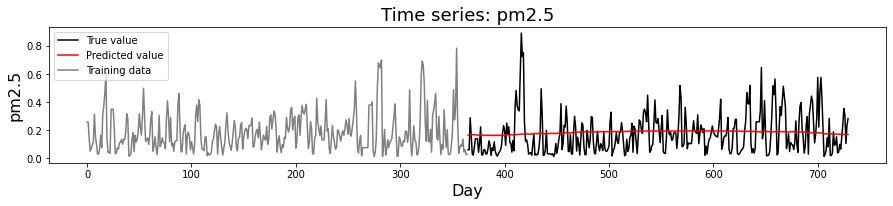

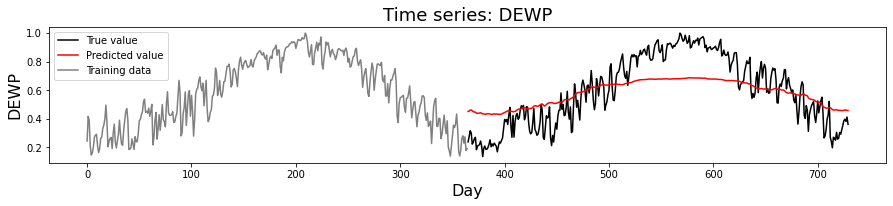

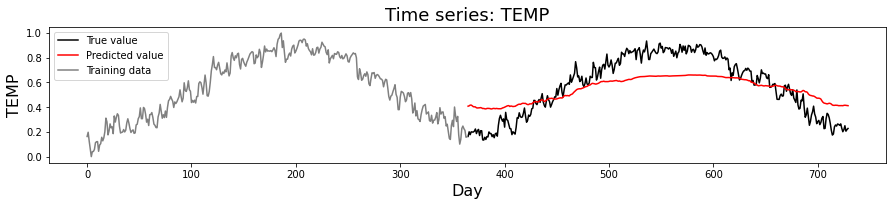

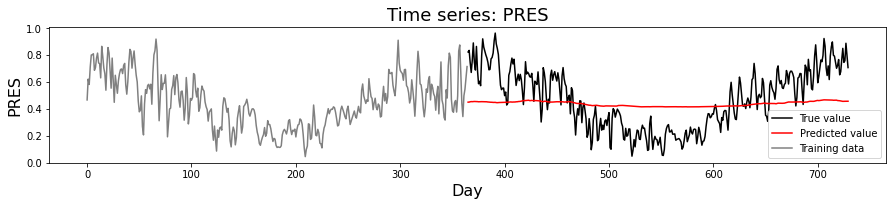

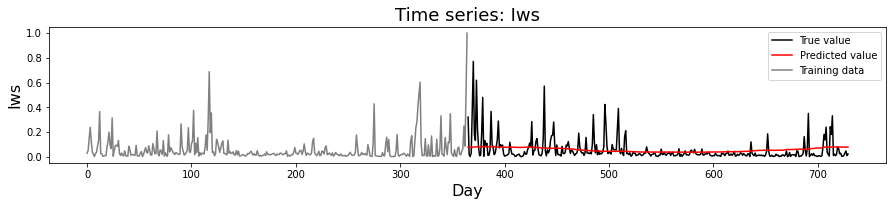

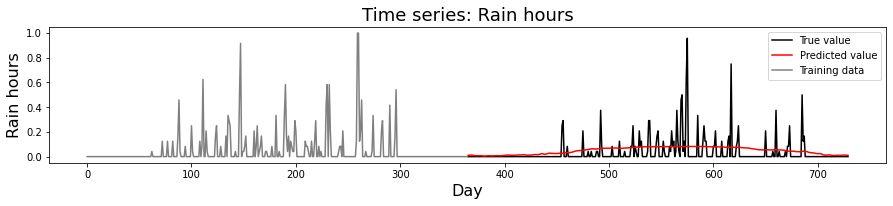

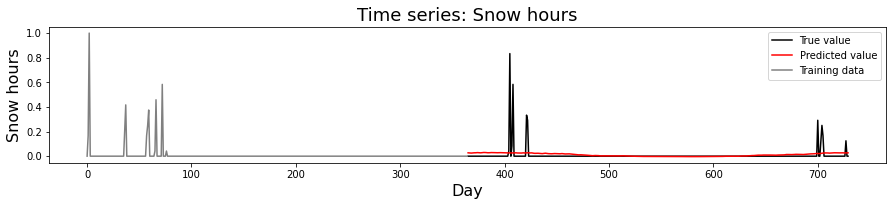

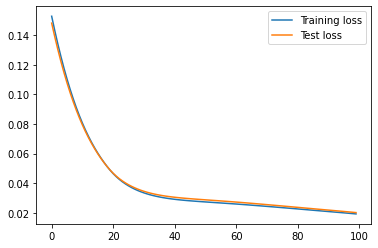

Model: "sequential_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_137 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_185 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.0999320008673518
MSE (interval):  0.020108720332680064
RMSE (interval):  0.14180521969476323
Epoch 1/100
15/15 - 0s - loss: 0.1501 - val_loss: 0.1362
Epoch 2/100
15/15 - 0s - loss: 0.1311 - val_loss: 0.1190
Epoch 3/100
15/15 - 0s - loss: 0.1144 - val_loss: 0.1039
Epoch 4/100
15/15 - 0s - loss: 0.0997 - val_loss: 0.0908
Epoch 5/100
15/15 - 0s - loss: 0.

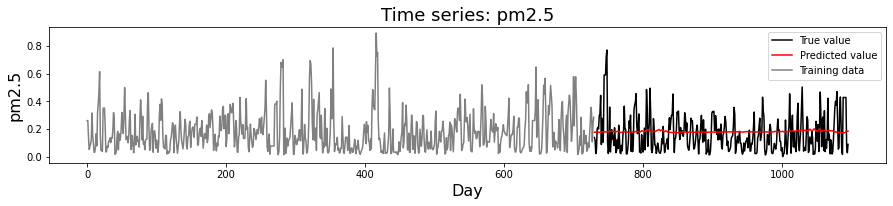

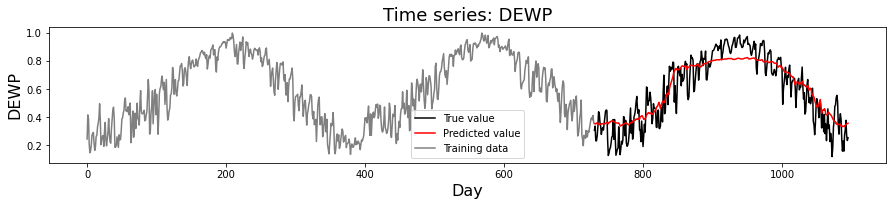

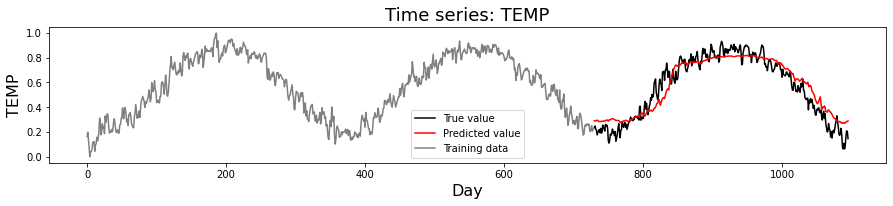

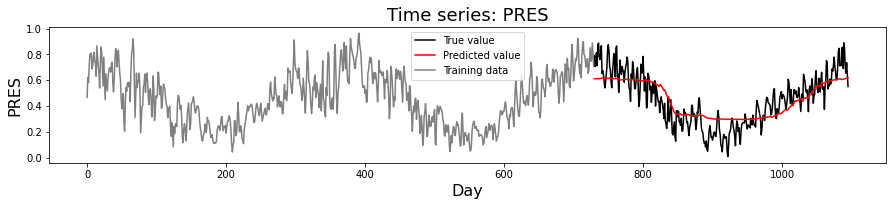

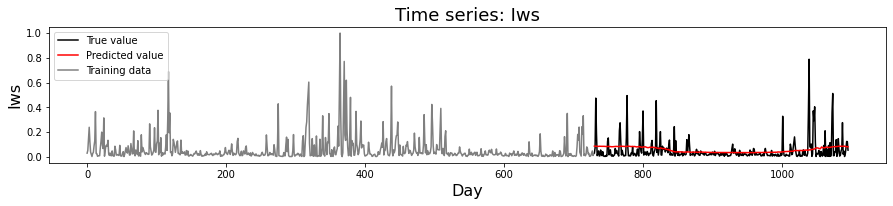

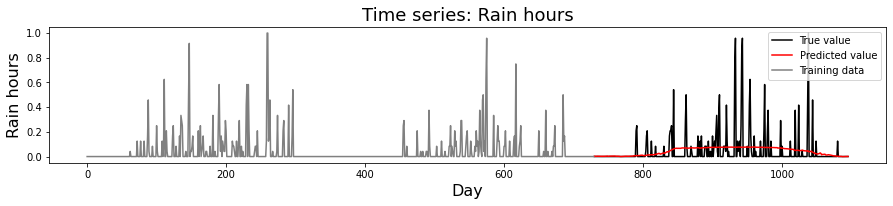

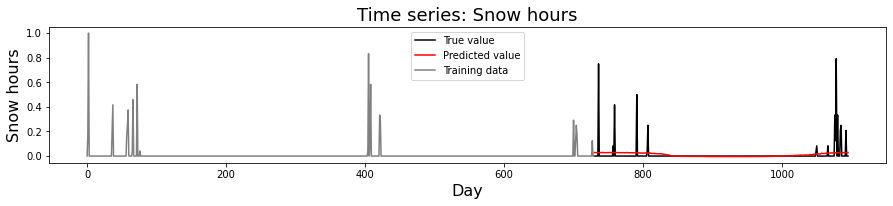

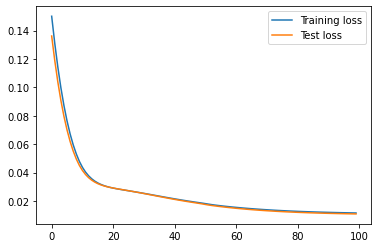

Model: "sequential_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_138 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_186 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.06823593791673115
MSE (interval):  0.010944827598904926
RMSE (interval):  0.10461753007457654
Epoch 1/100
22/22 - 0s - loss: 0.1474 - val_loss: 0.1293
Epoch 2/100
22/22 - 0s - loss: 0.1212 - val_loss: 0.1064
Epoch 3/100
22/22 - 0s - loss: 0.1001 - val_loss: 0.0879
Epoch 4/100
22/22 - 0s - loss: 0.0832 - val_loss: 0.0732
Epoch 5/100
22/22 - 0s - loss: 0

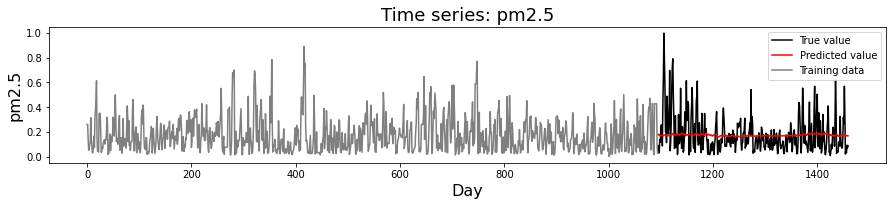

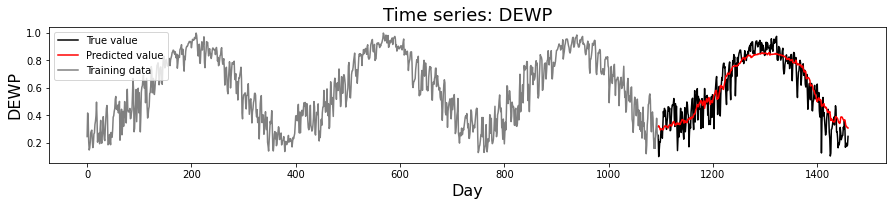

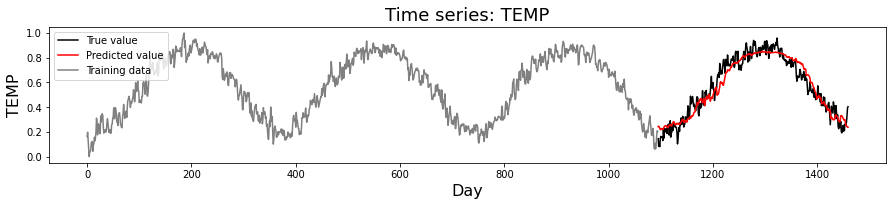

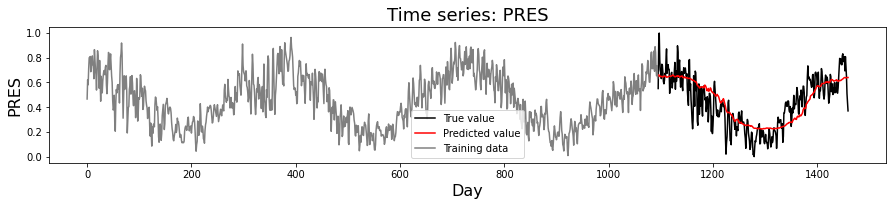

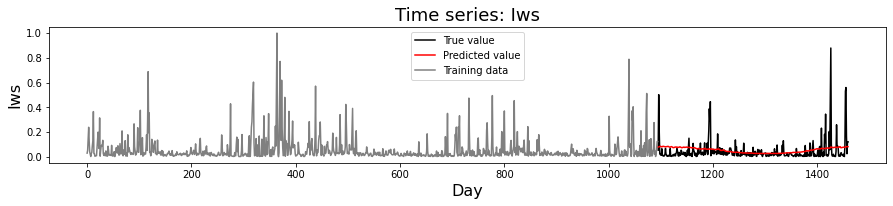

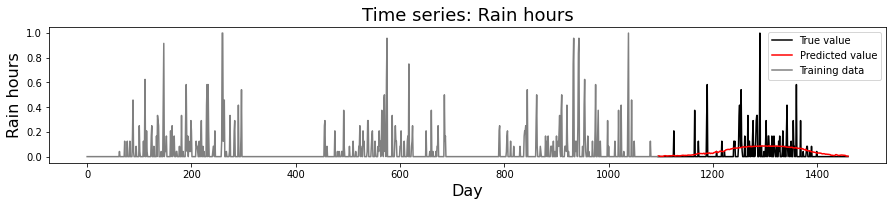

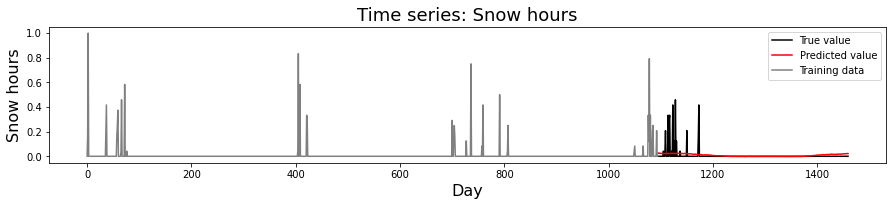

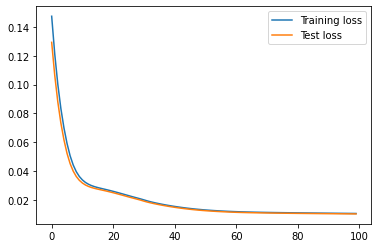

Model: "sequential_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_139 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_187 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.06457197190045495
MSE (interval):  0.010101734838427091
RMSE (interval):  0.10050738698437589
Epoch 1/100
29/29 - 0s - loss: 0.1370 - val_loss: 0.1209
Epoch 2/100
29/29 - 0s - loss: 0.1045 - val_loss: 0.0920
Epoch 3/100
29/29 - 0s - loss: 0.0798 - val_loss: 0.0705
Epoch 4/100
29/29 - 0s - loss: 0.0621 - val_loss: 0.0552
Epoch 5/100
29/29 - 0s - loss: 

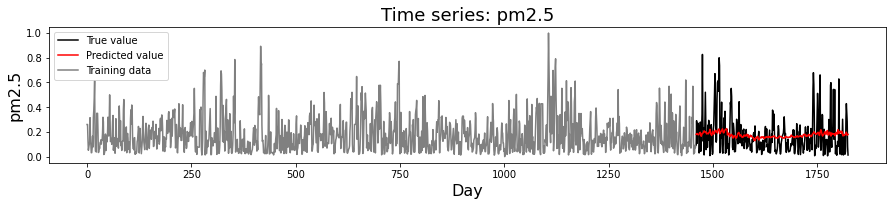

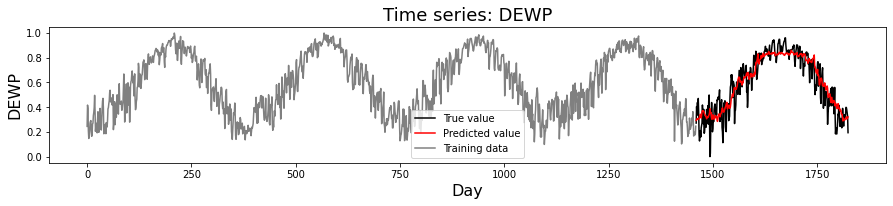

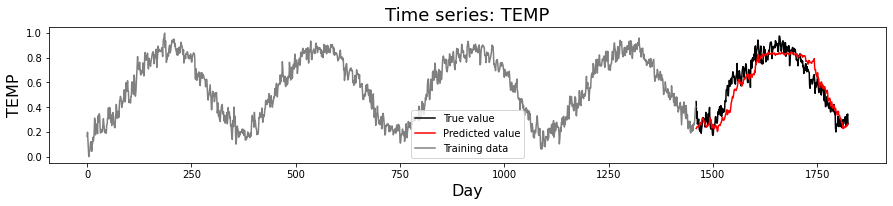

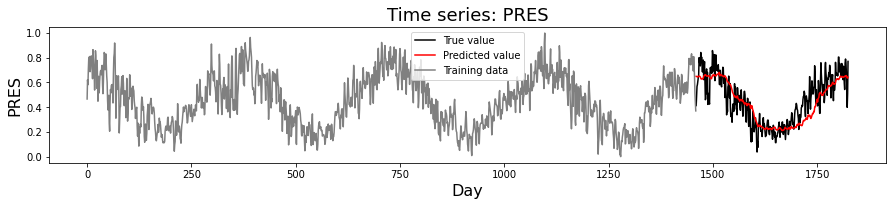

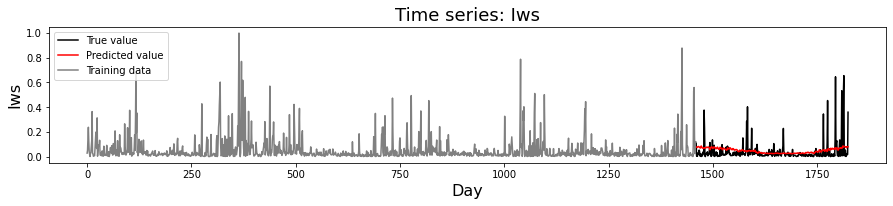

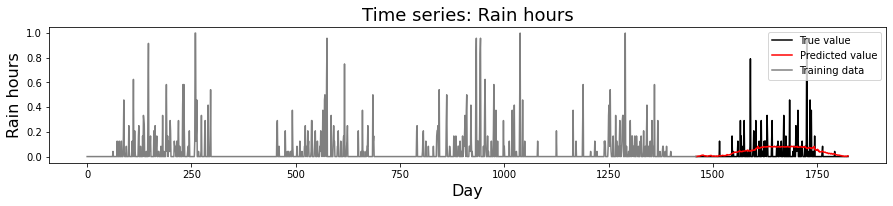

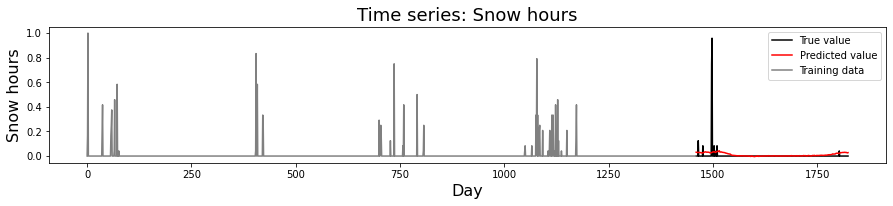

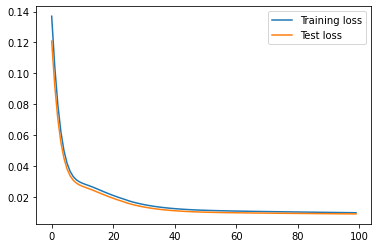

Model: "sequential_188"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_140 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_188 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 100
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.05973879958697962
MSE (interval):  0.008938076090539628
RMSE (interval):  0.09454139881839928


In [58]:
#this is a copy of the above function but produces visualizations with pyplot

#assume values are normalized, but could be interested to see results if they are not
#ARGUMENTS:
#df_arg = dataframe with normalized values, only features that are relevant
#time_lags = number of time steps to look back in time
#train_size = percentage of data (from the first normalized dataset, not the time-series shifted one) to use for training
#directions = 1 or 2, either unidirectional or bidirectional LSTM layers
#number_of_layers = do i really need to explain this?
#dropout_percent = dropout value for LSTM layers
#number_of_epochs = also pretty self explanatory
def LSTM_function_plot_predictions(df_arg, time_lags, train_size, directions, number_of_layers, dropout_percent, number_of_epochs):
  indices = ['pm2.5','DEWP','TEMP','PRES','Iws','Rain hours','Snow hours']

  #dfnl stands for dataframe normalized with lags
  dfnl = df_arg.copy()

  #set up time series with lags
  for i in range(1, time_lags):
    for ind in indices:
      dfnl[ind+'_lag_'+str(i)] = df_arg.shift(periods=i)[ind]

  #v for values
  dfnlv = dfnl.values.astype('float32')

  #what an ugly two lines of code! it's supposed to break up the test and train set into train_size percent, and 1-train_size percent for test
  train = dfnlv[time_lags:int(np.ceil(train_size*len(df_arg)))]
  test = dfnlv[int(np.ceil(train_size*len(df_arg))):int(np.ceil((train_size+0.2)*len(df_arg)))]

  #split into predicted and unpredicted values
  trainx, trainy = train[:, :7*(time_lags-1)], train[:, 7*(time_lags-1):]
  testx, testy = test[:, :7*(time_lags-1)], test[:, 7*(time_lags-1):]

  #reshape into the LSTM RNN desired shape
  trainxr = trainx.reshape((trainx.shape[0], 1, trainx.shape[1]))
  testxr = testx.reshape((testx.shape[0], 1, testx.shape[1]))
  
  #choice of model architecture, this should be modular depending on kwargs
  #you can actually add any number of layers if you want
  model = keras.Sequential()
  if (number_of_layers==1):
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))

  else:
    for i in range(number_of_layers-1):
      if (directions==1):
        model.add(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent))
      elif (directions==2):
        model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, activation='softmax', dropout=dropout_percent)))
    if (directions==1):
      model.add(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent))
    elif (directions==2):
      model.add(layers.Bidirectional(layers.LSTM(64, input_shape=(trainxr.shape[1], trainxr.shape[2]), activation='softmax', dropout=dropout_percent)))       
  model.add(layers.Dense(7))

  #compile with MSE and adam optimizer
  model.compile(loss='mse', optimizer='adam')

  history = model.fit(trainxr, trainy, epochs=number_of_epochs, batch_size=50, validation_data=(testxr, testy), verbose=2, shuffle=False)

  prediction_vector = model.predict(testxr)
  transposed_pv = np.transpose(prediction_vector)
  index_value = 0
  train_length = len(df_arg.iloc[0:int(np.ceil(train_size*len(df_arg)))])
  test_length = len(df_arg.iloc[int(np.ceil(train_size*len(df_arg))):int(np.ceil((train_size+0.2)*len(df_arg)))])
  train_day_list = list(range(0,train_length))
  test_day_list = list(range(train_length,test_length+train_length))
  for i in indices:
    fig = plt.figure(figsize =(15, 2.5)) 
    plt.title("Time series: " + i, size=18) 
    plt.xlabel('Day', size=16)
    plt.ylabel(i, size=16)
    plt.plot(test_day_list, df_arg[i].iloc[int(np.ceil(train_size*len(df_arg))):int(np.ceil((train_size+0.2)*len(df_arg)))], color = 'black', label = 'True value')
    plt.plot(test_day_list, transposed_pv[index_value],color = 'red', label = 'Predicted value')
    plt.plot(train_day_list, df_arg[i].iloc[0:int(np.ceil(train_size*len(df_arg)))], color = 'grey', label = 'Training data')
    plt.legend()
    plt.show()
    index_value+=1

  #plot the loss values 
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Test loss')
  plt.legend()
  plt.show()

  #model summary
  print(model.summary())
  print("Model parameters: ")
  print("Time lags: ", time_lags)
  print("Training set size: "+str(train_size*100)+"%, or "+str(train_size*1825-time_lags))
  print("Number of epochs: "+str(number_of_epochs))
  print("Number of layers: "+str(number_of_layers))
  print("Dropout percent: "+str(dropout_percent))
  mae_interval = calculate_mae_interval(model, testxr, testy)
  print("MAE (interval): ", mae_interval)
  mse_interval = calculate_mse_interval(model, testxr, testy)
  print("MSE (interval): ", mse_interval)
  rmse_interval = np.sqrt(calculate_mse_interval(model, testxr, testy))
  print("RMSE (interval): ", rmse_interval)  

  

  #return all parameters that you need for evaluation
  return [time_lags, train_size, directions, number_of_layers, dropout_percent, number_of_epochs, mae_interval, mse_interval, rmse_interval]
#  return model
for ts in [0.2,0.4,0.6,0.8]:
  LSTM_function_plot_predictions(df_normal, 20, ts, 2, 1, 0, 100)

Epoch 1/500
7/7 - 0s - loss: 0.1577 - val_loss: 0.1528
Epoch 2/500
7/7 - 0s - loss: 0.1476 - val_loss: 0.1433
Epoch 3/500
7/7 - 0s - loss: 0.1383 - val_loss: 0.1344
Epoch 4/500
7/7 - 0s - loss: 0.1296 - val_loss: 0.1261
Epoch 5/500
7/7 - 0s - loss: 0.1215 - val_loss: 0.1185
Epoch 6/500
7/7 - 0s - loss: 0.1140 - val_loss: 0.1114
Epoch 7/500
7/7 - 0s - loss: 0.1071 - val_loss: 0.1048
Epoch 8/500
7/7 - 0s - loss: 0.1006 - val_loss: 0.0986
Epoch 9/500
7/7 - 0s - loss: 0.0946 - val_loss: 0.0929
Epoch 10/500
7/7 - 0s - loss: 0.0891 - val_loss: 0.0876
Epoch 11/500
7/7 - 0s - loss: 0.0839 - val_loss: 0.0827
Epoch 12/500
7/7 - 0s - loss: 0.0791 - val_loss: 0.0781
Epoch 13/500
7/7 - 0s - loss: 0.0746 - val_loss: 0.0737
Epoch 14/500
7/7 - 0s - loss: 0.0703 - val_loss: 0.0697
Epoch 15/500
7/7 - 0s - loss: 0.0664 - val_loss: 0.0659
Epoch 16/500
7/7 - 0s - loss: 0.0627 - val_loss: 0.0623
Epoch 17/500
7/7 - 0s - loss: 0.0593 - val_loss: 0.0591
Epoch 18/500
7/7 - 0s - loss: 0.0562 - val_loss: 0.0561
E

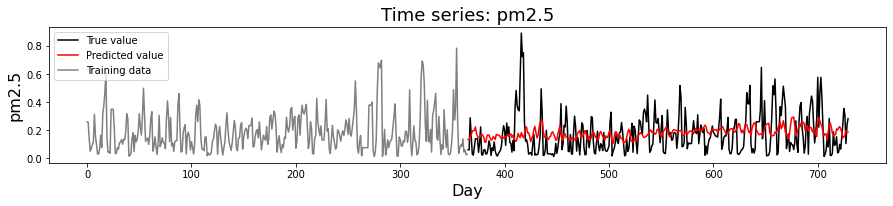

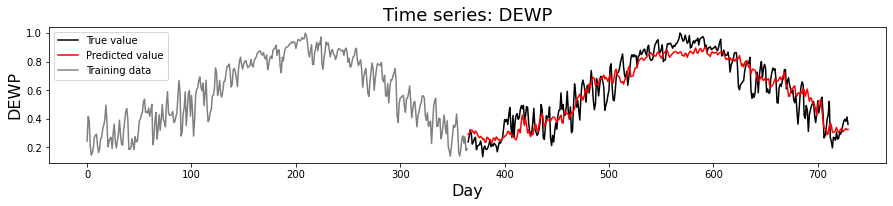

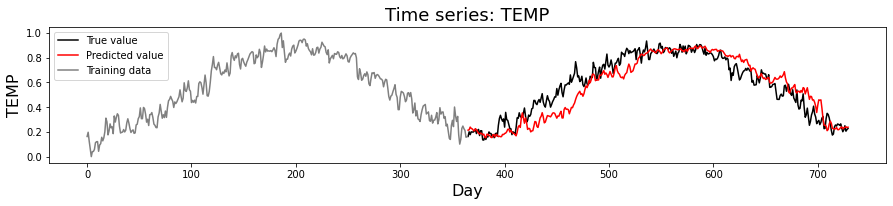

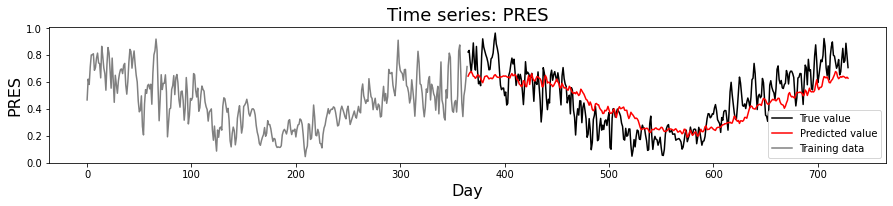

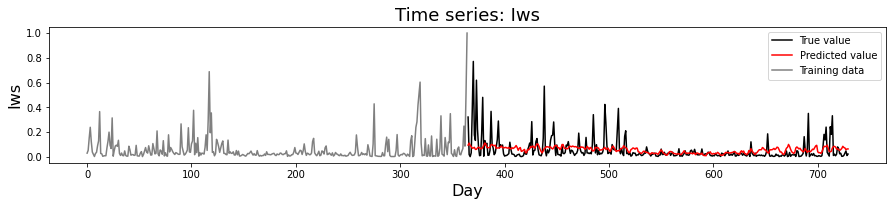

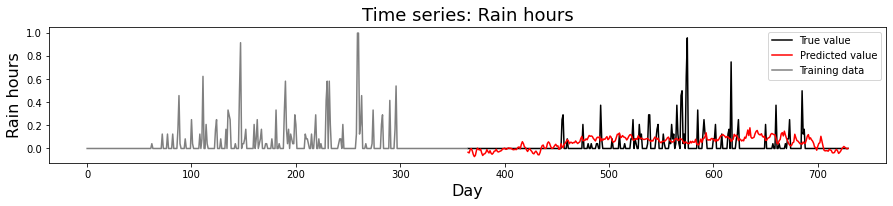

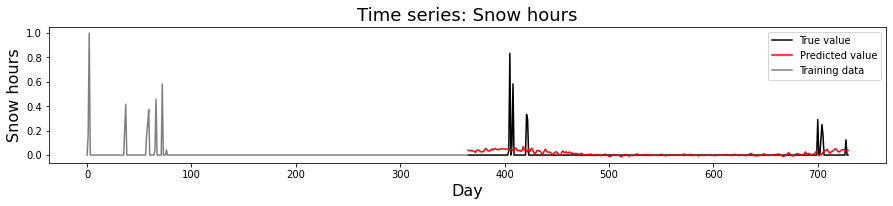

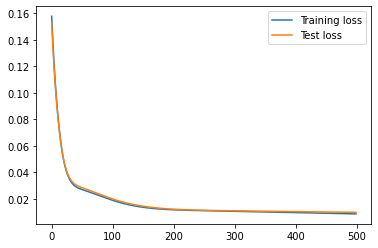

Model: "sequential_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_141 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_189 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 20.0%, or 345.0
Number of epochs: 500
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.06604975226276906
MSE (interval):  0.009928712926806815
RMSE (interval):  0.09964292712885754
Epoch 1/500
15/15 - 0s - loss: 0.1479 - val_loss: 0.1345
Epoch 2/500
15/15 - 0s - loss: 0.1294 - val_loss: 0.1177
Epoch 3/500
15/15 - 0s - loss: 0.1131 - val_loss: 0.1030
Epoch 4/500
15/15 - 0s - loss: 0.0988 - val_loss: 0.0900
Epoch 5/500
15/15 - 0s - loss: 0

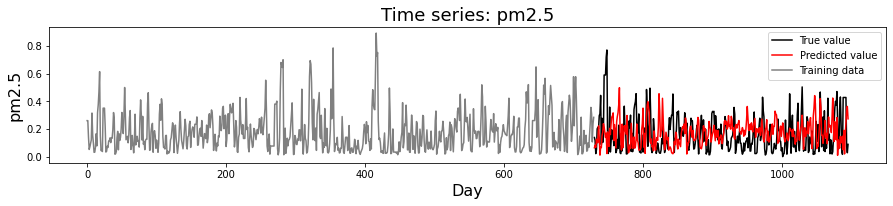

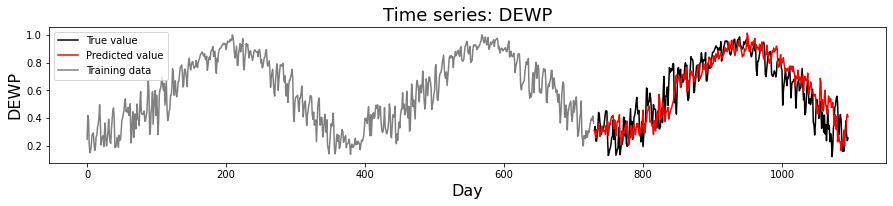

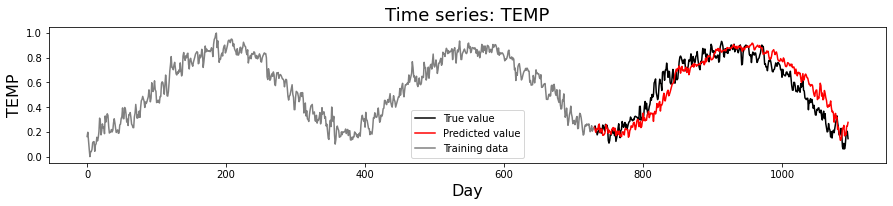

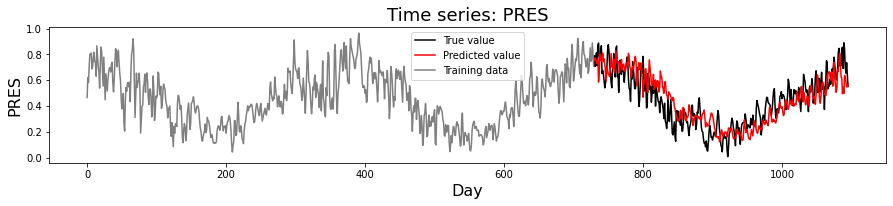

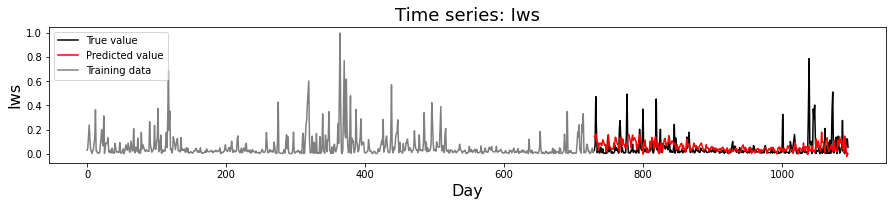

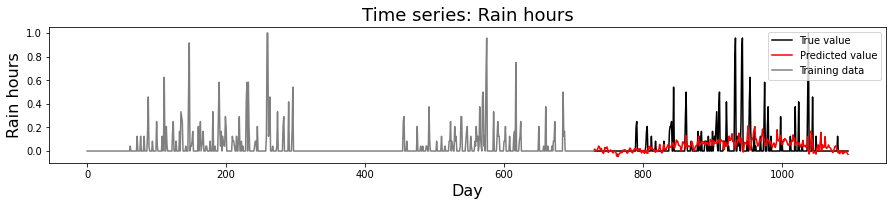

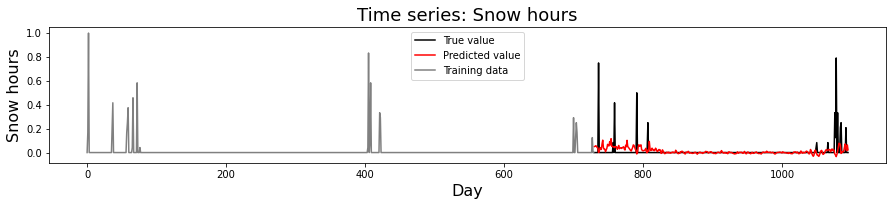

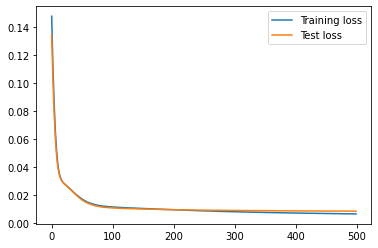

Model: "sequential_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_142 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_190 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 40.0%, or 710.0
Number of epochs: 500
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.0575558248148992
MSE (interval):  0.008425422965272673
RMSE (interval):  0.09179010276316653
Epoch 1/500
22/22 - 0s - loss: 0.1431 - val_loss: 0.1256
Epoch 2/500
22/22 - 0s - loss: 0.1173 - val_loss: 0.1025
Epoch 3/500
22/22 - 0s - loss: 0.0960 - val_loss: 0.0837
Epoch 4/500
22/22 - 0s - loss: 0.0790 - val_loss: 0.0691
Epoch 5/500
22/22 - 0s - loss: 0.

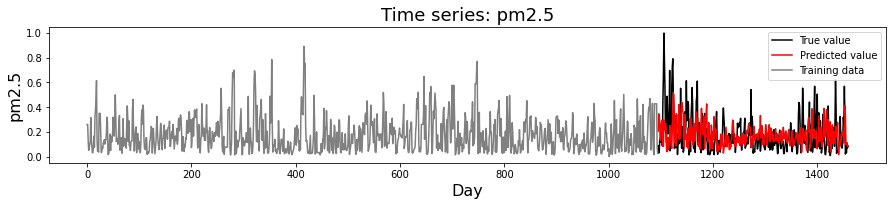

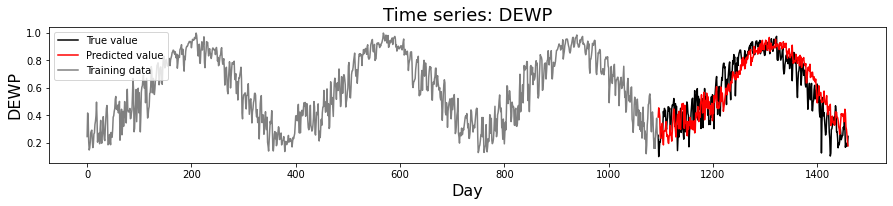

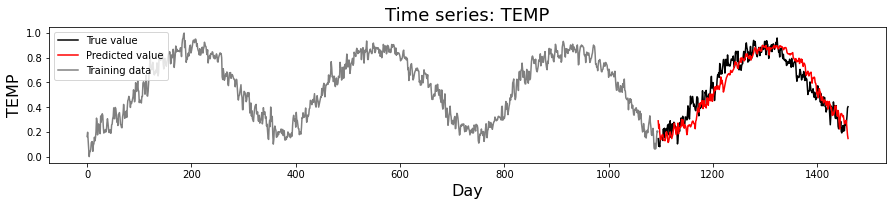

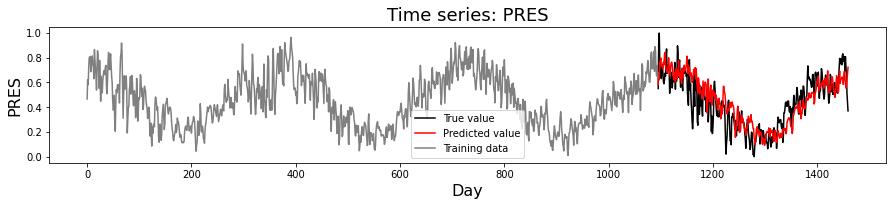

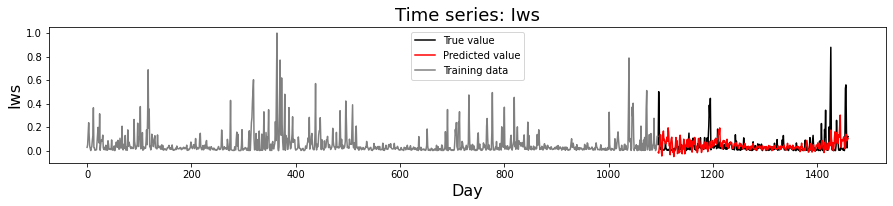

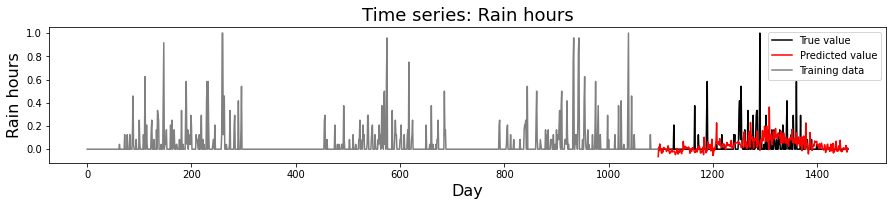

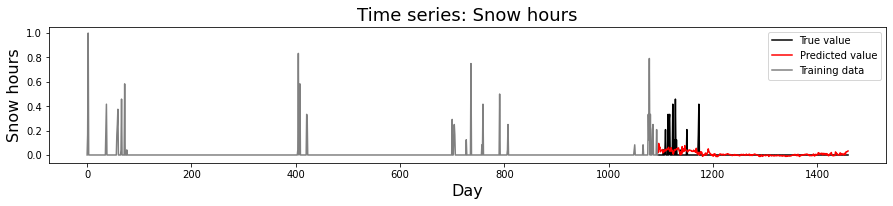

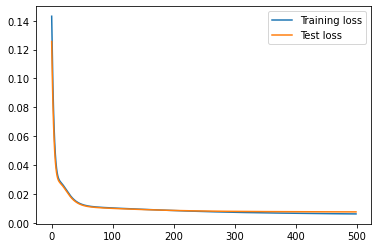

Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_143 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_191 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 60.0%, or 1075.0
Number of epochs: 500
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.05495383311787515
MSE (interval):  0.007713061854889614
RMSE (interval):  0.0878240391629172
Epoch 1/500
29/29 - 0s - loss: 0.1412 - val_loss: 0.1253
Epoch 2/500
29/29 - 0s - loss: 0.1087 - val_loss: 0.0961
Epoch 3/500
29/29 - 0s - loss: 0.0836 - val_loss: 0.0741
Epoch 4/500
29/29 - 0s - loss: 0.0652 - val_loss: 0.0580
Epoch 5/500
29/29 - 0s - loss: 0

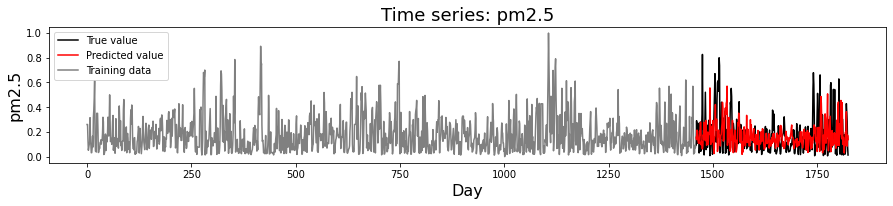

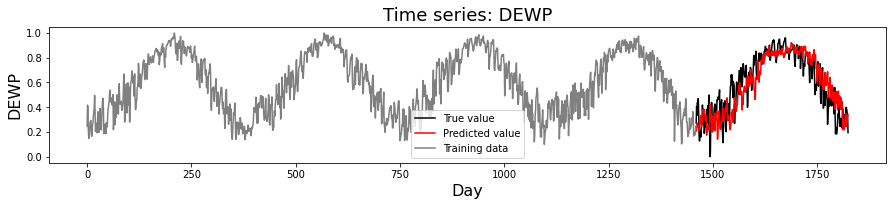

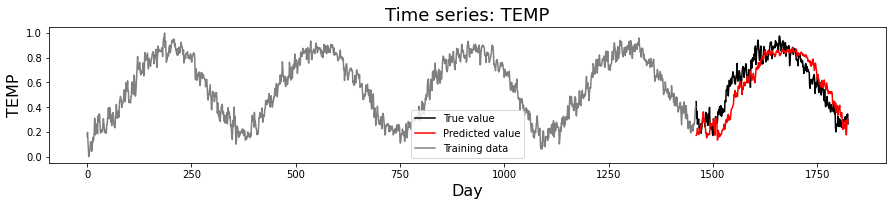

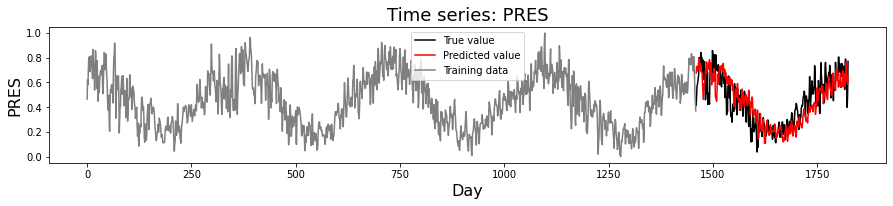

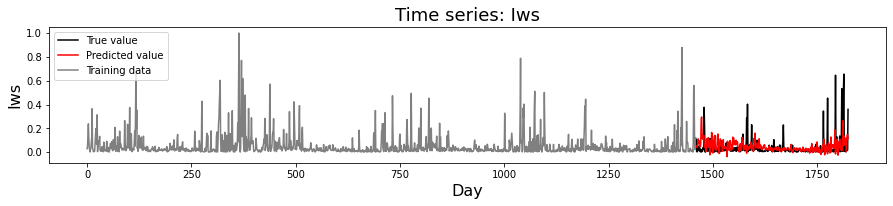

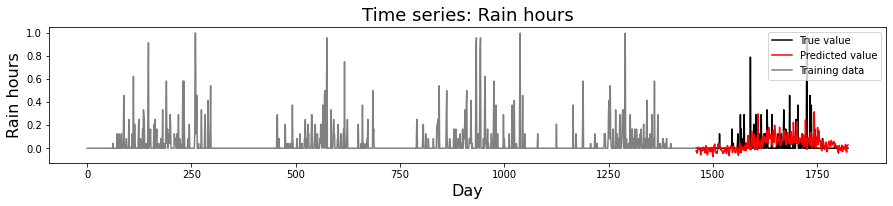

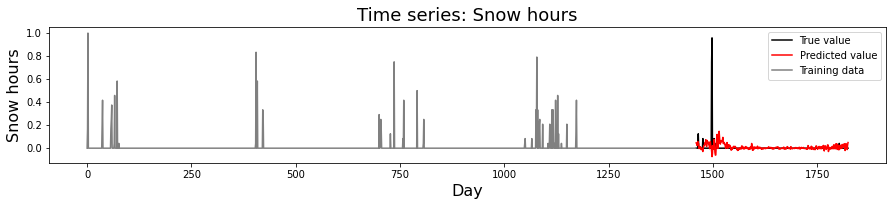

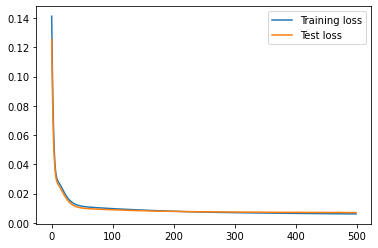

Model: "sequential_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_144 (Bidirecti (None, 128)               101376    
_________________________________________________________________
dense_192 (Dense)            (None, 7)                 903       
Total params: 102,279
Trainable params: 102,279
Non-trainable params: 0
_________________________________________________________________
None
Model parameters: 
Time lags:  20
Training set size: 80.0%, or 1440.0
Number of epochs: 500
Number of layers: 1
Dropout percent: 0
MAE (interval):  0.05237182061955216
MSE (interval):  0.0070384169833114995
RMSE (interval):  0.08389527390331054


In [59]:
for ts in [0.2,0.4,0.6,0.8]:
  LSTM_function_plot_predictions(df_normal, 20, ts, 2, 1, 0, 500)